# Disable GPU

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Imports

In [2]:
%matplotlib inline
import importlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Add, Input
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D, Dense, AvgPool2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test simple network

In [5]:
class ConvBlock():    
    def __init__(self, filter_mult, activation='relu', padding='same'):
        self.layers = dict(
            bn1 = BatchNormalization(),
            ac1 = Activation(activation),
            conv1 = Conv2D(32 * filter_mult, (3, 3), activation="linear", padding="valid"),
            bn2 = BatchNormalization(),
            ac2 = Activation(activation),
            conv2 = Conv2D(32 * filter_mult, (3, 3), activation="linear", padding="valid")            
        )
    def __call__(self, input_x):
        x = self.layers['bn1'](input_x)
        x = self.layers['ac1'](x)
        x = self.layers['conv1'](x)
        x = self.layers['bn2'](x)
        x = self.layers['ac2'](x)
        x = self.layers['conv2'](x) 
        return x


activation = 'linear'
padding='same'
def model_build_func(input_shape):
    
    inp = Input(shape=input_shape, name='input_image')
    x = Conv2D(32, (5, 5), padding=padding, activation=activation)(inp)
    x = ConvBlock(1, activation, padding)(x)
    x = Conv2D(32, (1, 1), activation=activation, padding=padding, name='conv0')(x)
    x = AvgPool2D()(x)
    x = ConvBlock(2, activation, padding)(x)
    x = Conv2D(64, (1, 1), activation=activation, padding=padding, name='conv1')(x)
    x = AvgPool2D()(x)
    x = ConvBlock(3, activation, padding)(x)
    x = Conv2D(128, (3, 3), activation=activation, padding=padding, name='conv2')(x)

    model = Model(inp, x)
    return model

model = model_build_func(input_shape=(None, None, 3))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 32)    2432      
_________________________________________________________________
batch_normalization_6 (Batch (None, None, None, 32)    128       
_________________________________________________________________
activation_6 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, None, None, 32)    128       
_________________________________________________________________
activation_7 (Activation)    (None, None, None, 32)    0   

## Load example image

In [6]:
from receptivefield.image import get_default_image

image = get_default_image(shape=(64, 64), tile_factor=0, name='cat')
image.shape

(64, 64, 3)

## Compute RF params for that network

In [7]:
from receptivefield.keras import KerasReceptiveField
rf = KerasReceptiveField(model_build_func, init_weights=False)
rf_params = rf.compute(input_shape=image.shape, input_layer='input_image', output_layers=['conv0', 'conv1', 'conv2'])
rf_params

[2019-12-11 19:52:57,538][ INFO][keras.py]::Feature maps shape: [[None, 60, 60, 1], [None, 26, 26, 1], [None, 9, 9, 1]]
[2019-12-11 19:52:57,539][ INFO][keras.py]::Input shape       : (None, 64, 64, 3)
[2019-12-11 19:52:58,027][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(2.5, 2.5), stride=(1.0, 1.0), size=Size(w=9, h=9))
[2019-12-11 19:52:58,028][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=18, h=18))
[2019-12-11 19:52:58,028][ INFO][base.py]::Estimated receptive field for feature map [2]: ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=44, h=44))


[FeatureMapDescription(size=Size(w=60, h=60), rf=ReceptiveFieldDescription(offset=(2.5, 2.5), stride=(1.0, 1.0), size=Size(w=9, h=9))),
 FeatureMapDescription(size=Size(w=26, h=26), rf=ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=18, h=18))),
 FeatureMapDescription(size=Size(w=9, h=9), rf=ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=44, h=44)))]

In [8]:
rf.input_shape, rf.output_shapes

(ImageShape(w=64, h=64, c=3),
 [Size(w=60, h=60), Size(w=26, h=26), Size(w=9, h=9)])

In [9]:
rf.feature_maps_desc

[FeatureMapDescription(size=Size(w=60, h=60), rf=ReceptiveFieldDescription(offset=(2.5, 2.5), stride=(1.0, 1.0), size=Size(w=9, h=9))),
 FeatureMapDescription(size=Size(w=26, h=26), rf=ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=18, h=18))),
 FeatureMapDescription(size=Size(w=9, h=9), rf=ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=44, h=44)))]

### Plot example receptive field response

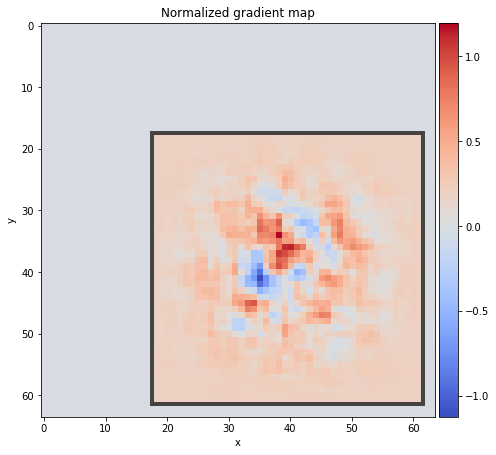

In [10]:
rf.plot_gradient_at(fm_id=2, point=(6, 6), image=None, figsize=(7, 7))

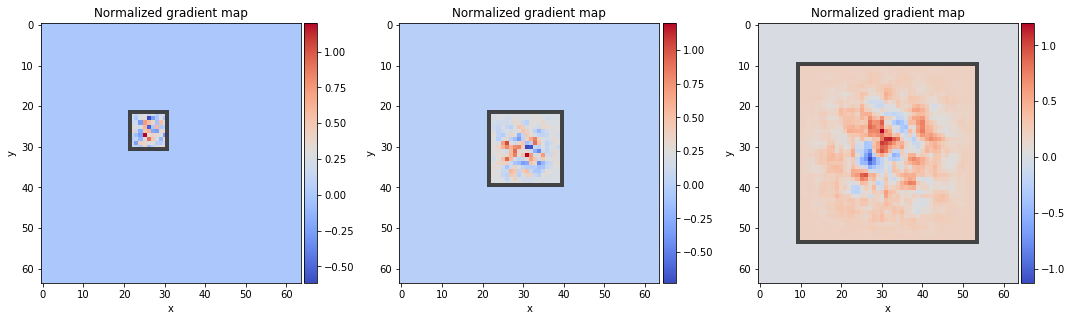

In [11]:
rf.plot_gradients_at(points=[(24, 24), (12, 12), (4, 4)], layout=(1, 3), figsize=(15, 8))

### Debug receptive field

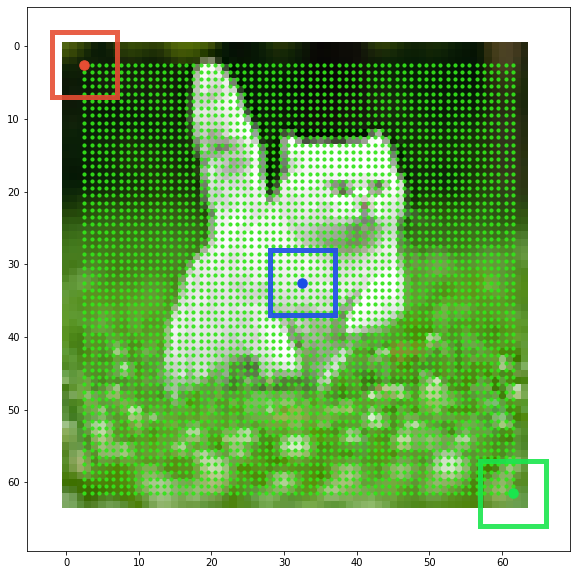

In [12]:
rf.plot_rf_grid(fm_id=0, custom_image=image, figsize=(10, 10))

### Plot all feature maps 

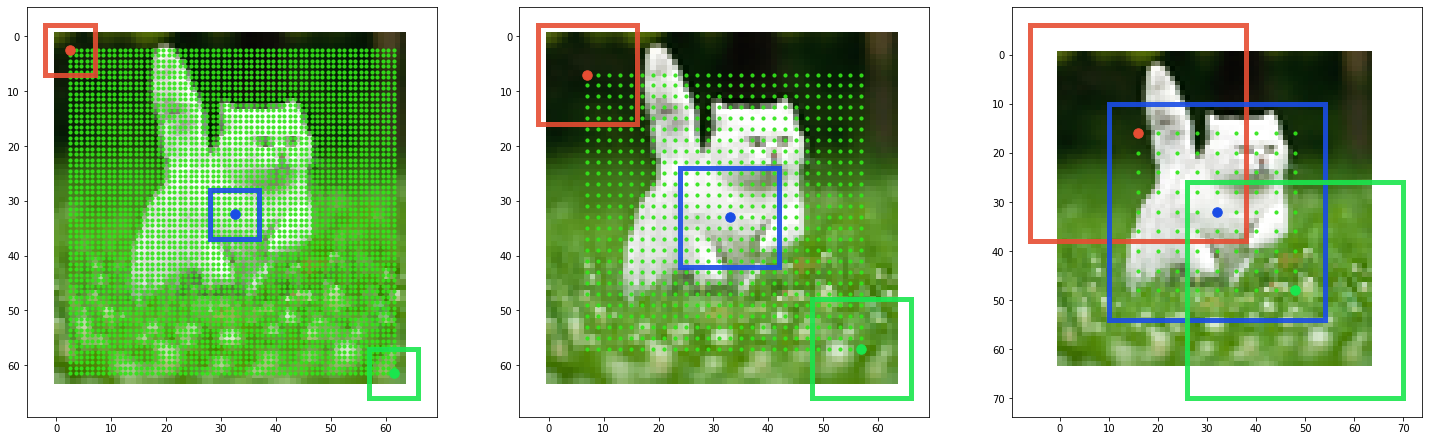

In [13]:
rf.plot_rf_grids(custom_image=image, figsize=(25, 15), layout=(1, 3))
plt.savefig("../img/demo.jpg", dpi=126)

## Same but using subplots

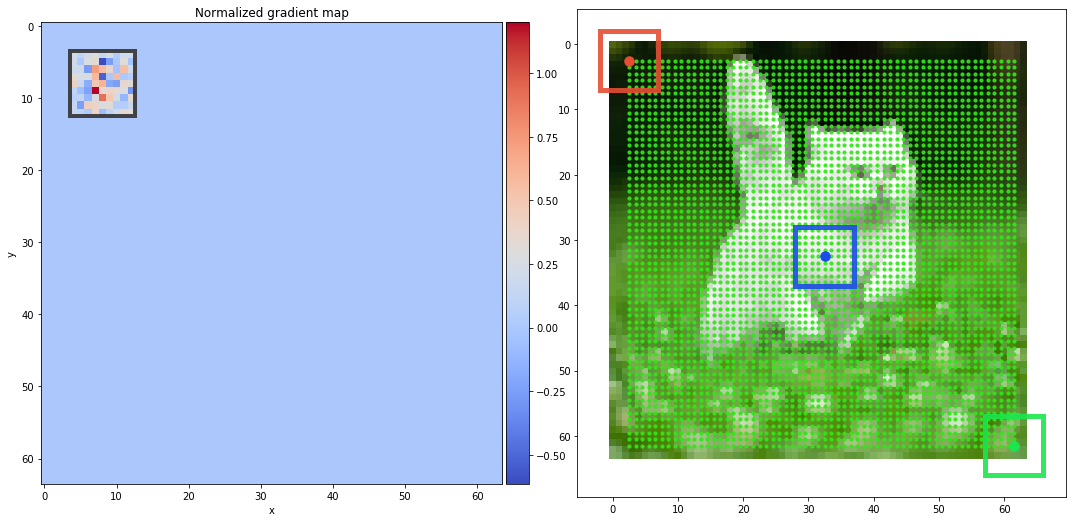

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
ax = plt.subplot(121)
rf.plot_gradient_at(0, (6, 6), image=None, axis=ax)
ax = plt.subplot(122)
rf.plot_rf_grid(0, custom_image=image, axis=ax)

## Test inception network

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

In [15]:
def inception_build_func(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape, name='input_image')
    model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=None)
    return model

inception_model = inception_build_func()

87916544/87910968 [==============================] - 518s 6us/step


In [16]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 111, 111, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 111, 111, 32) 96          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 111, 111, 32) 0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_16 

## Receptive field for layer `mixed4`

Note that there are 10 `mixed` layers but allready at 4-th one the receptive field is bigger than
the input image.

In [18]:
from receptivefield.keras import KerasReceptiveField
from receptivefield.image import get_default_image

image = get_default_image(shape=(224, 224), tile_factor=1)

inception_rf = KerasReceptiveField(inception_build_func, init_weights=False)
inception_rf.compute(input_shape=image.shape, input_layer='input_image', output_layers=['mixed4'])

[2018-07-21 05:56:42,394][ INFO][keras.py]::Feature maps shape: [[None, 40, 40, 1]]
[2018-07-21 05:56:42,395][ INFO][keras.py]::Input shape       : (None, 672, 672, 3)
[2018-07-21 05:56:48,096][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(15.5, 15.5), stride=(16.0, 16.0), size=Size(w=339, h=339))


[FeatureMapDescription(size=Size(w=40, h=40), rf=ReceptiveFieldDescription(offset=(15.5, 15.5), stride=(16.0, 16.0), size=Size(w=339, h=339)))]

In [19]:
inception_rf.feature_maps_desc

[FeatureMapDescription(size=Size(w=40, h=40), rf=ReceptiveFieldDescription(offset=(15.5, 15.5), stride=(16.0, 16.0), size=Size(w=339, h=339)))]

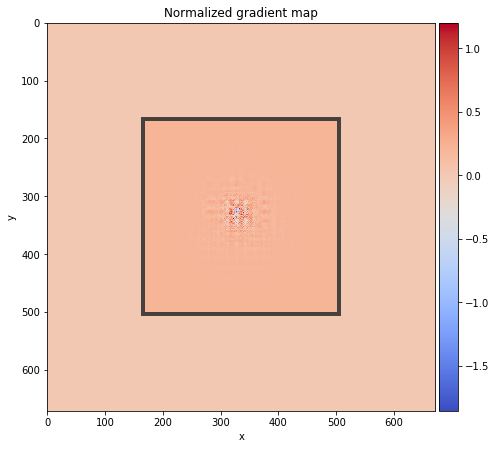

In [20]:
inception_rf.plot_gradient_at(0, (20, 20), image=None, figsize=(7, 7))

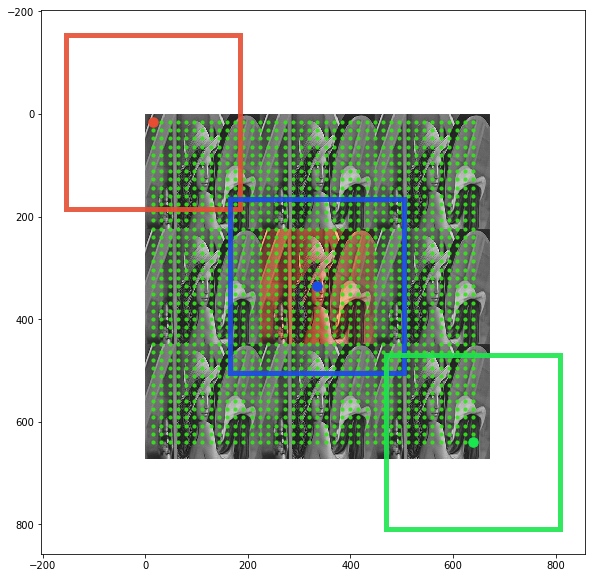

In [21]:
inception_rf.plot_rf_grid(0, custom_image=image, figsize=(10, 10))